In [1]:
! mkdir df_final

https://www.kaggle.com/flo2607/traffic-signs-classification

## **Unzipping the data**

In [2]:
! unzip archive.zip -d df_final

Streaming output truncated to the last 5000 lines.
  inflating: df_final/myData/8/00015_00010.jpg  
  inflating: df_final/myData/8/00015_00011.jpg  
  inflating: df_final/myData/8/00015_00012.jpg  
  inflating: df_final/myData/8/00015_00013.jpg  
  inflating: df_final/myData/8/00015_00014.jpg  
  inflating: df_final/myData/8/00015_00015.jpg  
  inflating: df_final/myData/8/00015_00016.jpg  
  inflating: df_final/myData/8/00015_00017.jpg  
  inflating: df_final/myData/8/00015_00018.jpg  
  inflating: df_final/myData/8/00015_00019.jpg  
  inflating: df_final/myData/8/00015_00020.jpg  
  inflating: df_final/myData/8/00015_00021.jpg  
  inflating: df_final/myData/8/00015_00022.jpg  
  inflating: df_final/myData/8/00015_00023.jpg  
  inflating: df_final/myData/8/00015_00024.jpg  
  inflating: df_final/myData/8/00015_00025.jpg  
  inflating: df_final/myData/8/00015_00026.jpg  
  inflating: df_final/myData/8/00015_00027.jpg  
  inflating: df_final/myData/8/00015_00028.jpg  
  inflating: df_fi

In [3]:
def img_preprocessing(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.equalizeHist(img)
  img = img/255
  return img

## **Loading Datasets**

In [5]:
import os
import cv2
import numpy as np

dataset = os.listdir('/content/df_final/myData')
print("Importing datasets------------")
c=0
image_arr=[]
num_classes=[]
for classes in dataset:
  img_list = os.listdir('/content/df_final/myData/'+str(c))
  for files in img_list:
    img = cv2.imread('/content/df_final/myData/'+str(c)+'/'+files)
    image_arr.append(img)
    num_classes.append(c)
  if c%7==0:
    print(c," class imported")
  if c == 42:
    
    print('Import Successfull')
  c +=1

img_set = np.array(image_arr)
class_num = np.array(num_classes)

Importing datasets------------
0  class imported
7  class imported
14  class imported
21  class imported
28  class imported
35  class imported
42  class imported
Import Successfull


In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(img_set,class_num,test_size=0.2)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)

In [7]:
X_train = np.array(list(map(img_preprocessing,X_train)))
X_val = np.array(list(map(img_preprocessing,X_val)))
X_test = np.array(list(map(img_preprocessing,X_test)))

In [8]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2],1)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             rotation_range=10,
                             horizontal_flip = False,
                             )
datagen.fit(X_train)

In [10]:
import pandas as pd

data_class = pd.read_csv('/content/df_final/labels.csv')
data_class.head()

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [11]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train,len(dataset))
y_val = to_categorical(y_val,len(dataset))
y_test = to_categorical(y_test,len(dataset))

In [12]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D

model = Sequential()
model.add(Conv2D(64,(5,5),input_shape= (32,32,1),activation='relu'))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(43,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0

In [13]:
from keras.optimizers import Adam

model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
import tensorflow as tf

checkpoint_dir = os.path.dirname('/content/weights.ckpt')
cp_callback = tf.keras.callbacks.ModelCheckpoint('/content/weights.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

hist = model.fit_generator(datagen.flow(X_train,y_train,batch_size=32),steps_per_epoch=1000,epochs=10,verbose=1,callbacks=[cp_callback],validation_data=(X_val,y_val))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 332s 316ms/step - loss: 2.5078 - accuracy: 0.3148 - val_loss: 0.2875 - val_accuracy: 0.9083

Epoch 00001: saving model to /content/weights.ckpt
Epoch 2/10
1000/1000 [==============================] - 313s 313ms/step - loss: 0.6772 - accuracy: 0.7929 - val_loss: 0.1127 - val_accuracy: 0.9644

Epoch 00002: saving model to /content/weights.ckpt
Epoch 3/10
1000/1000 [==============================] - 316s 316ms/step - loss: 0.4258 - accuracy: 0.8663 - val_loss: 0.0719 - val_accuracy: 0.9770

Epoch 00003: saving model to /content/weights.ckpt
Epoch 4/10
1000/1000 [==============================] - 317s 317ms/step - loss: 0.3256 - accuracy: 0.8996 - val_loss: 0.0498 - val_accuracy: 0.9849

Epoch 00004: saving model to /content/weights.ckpt
Epoch 5/10
1000/1000 [==============================] - 316s 316ms/step - loss: 0.2745 - accuracy: 0.9119 - val_loss: 0.0620 - val_accuracy: 0.9809

Epoch 00005: saving model to /content/weights.ckpt


# **Test Accuracy**

In [15]:
score = model.evaluate(X_test,y_test,verbose=1)

458/458 [==============================] - 29s 64ms/step - loss: 0.0321 - accuracy: 0.9911


In [17]:
accuracy = score[1]
print("The model have a test accuracy of {:.3f}%".format(accuracy*100))

The model have a test accuracy of 99.111%


## **Plots**

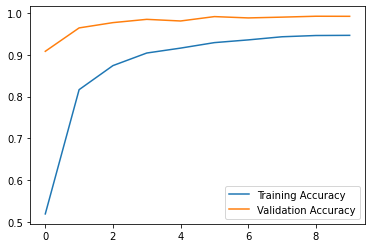

In [19]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

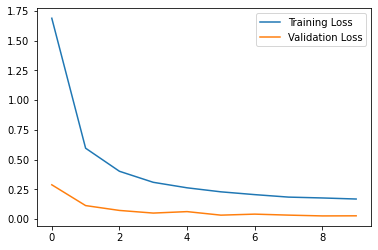

In [20]:
plt.plot(hist.history['loss'],label ='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()